This notebook motivated by how in March, there is a sudden increase in bad chirps (output from A11 winter below, generated using `clipping.ipynb`. 
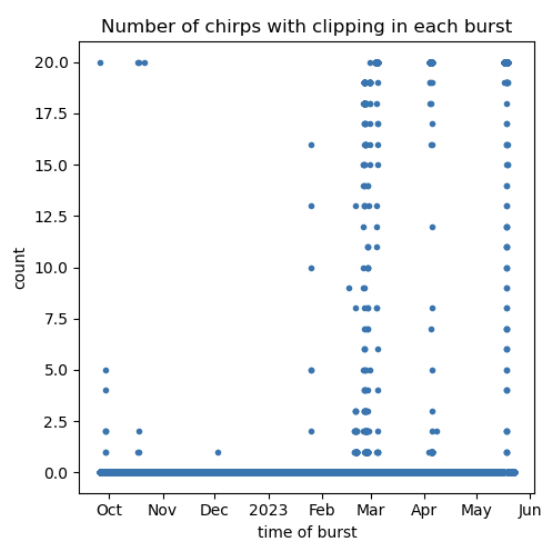

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    14:32:29 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    14:32:29 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    14:32:29 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46181")
client

<Client: 'tcp://127.0.0.1:46181' processes=4 threads=16, memory=125.81 GiB>

In [4]:
snippet = ds_101_w.isel(attenuator_setting_pair = 0,time=range(8000,22000),chirp_time=range(200,39999))

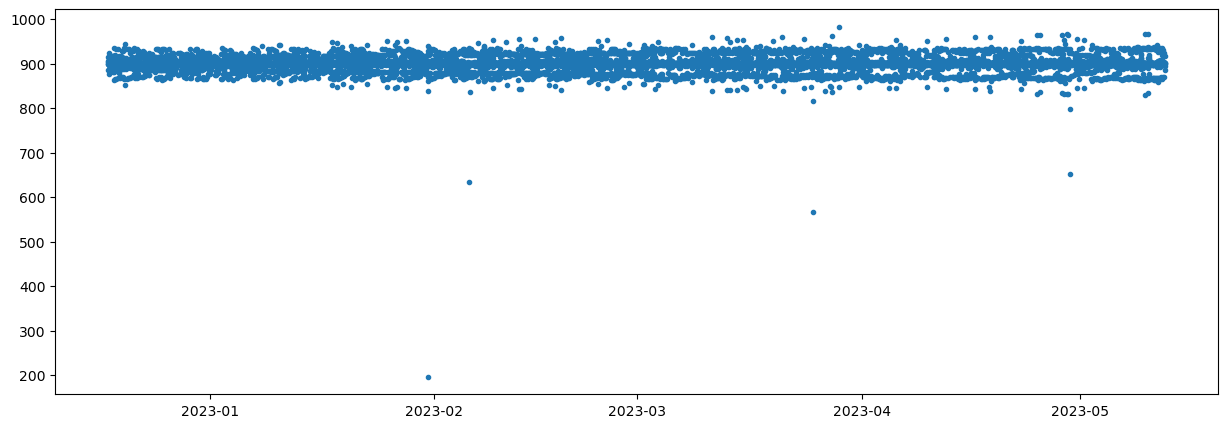

In [5]:
# Check sampling frequency
fig, ax = plt.subplots(figsize=(15,5))
diffs = snippet.time.diff(dim='time').values.astype('float64')/1e9
ax.plot(snippet.time.values[0:-1], diffs,linestyle='None',marker='.')

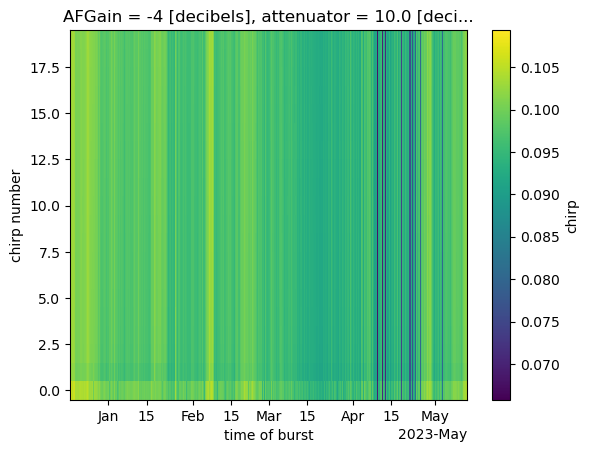

In [6]:
np.abs(snippet.chirp).mean(dim='chirp_time').plot(x='time')

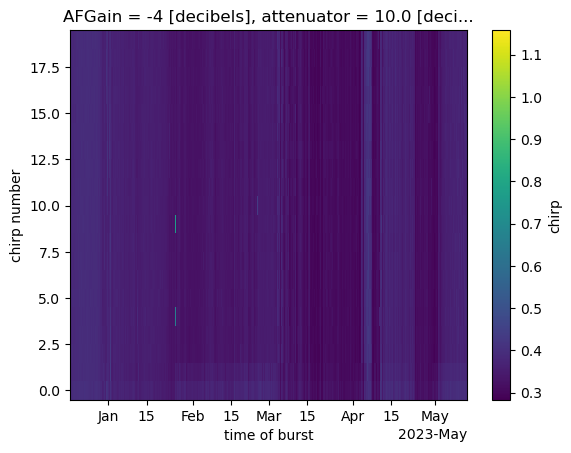

In [6]:
np.abs(snippet.chirp).max(dim='chirp_time').plot(x='time')

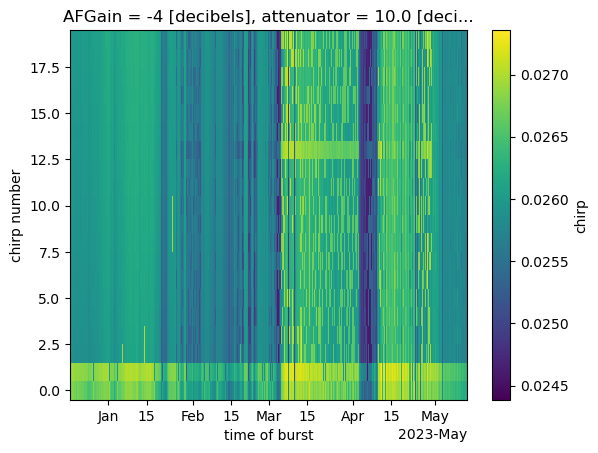

In [7]:
snippet.chirp.mean(dim='chirp_time').plot(x='time')

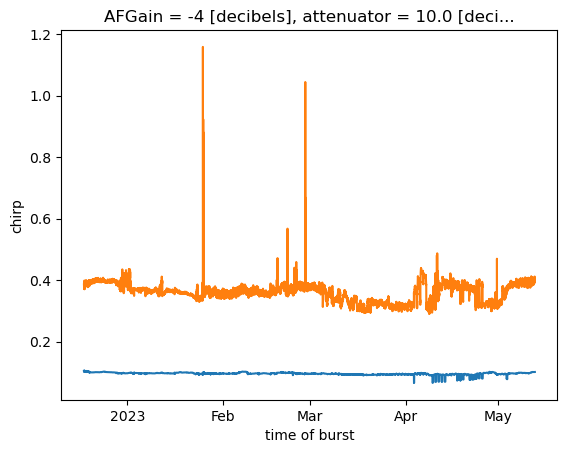

In [7]:
np.abs(snippet.chirp).mean(dim=['chirp_time','chirp_num']).plot()
np.abs(snippet.chirp).max(dim=['chirp_time','chirp_num']).plot()

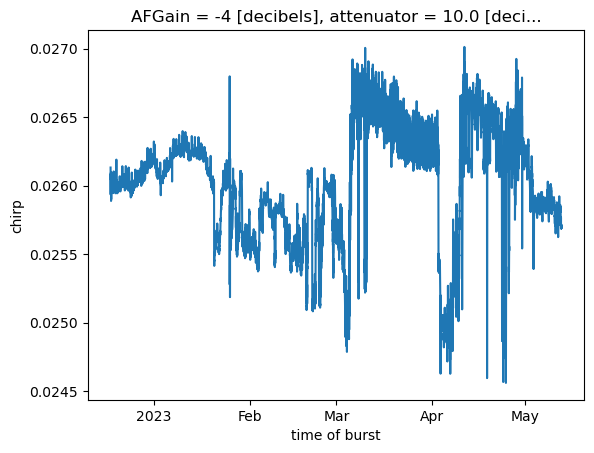

In [9]:
snippet.chirp.mean(dim=['chirp_time','chirp_num']).plot(x='time')

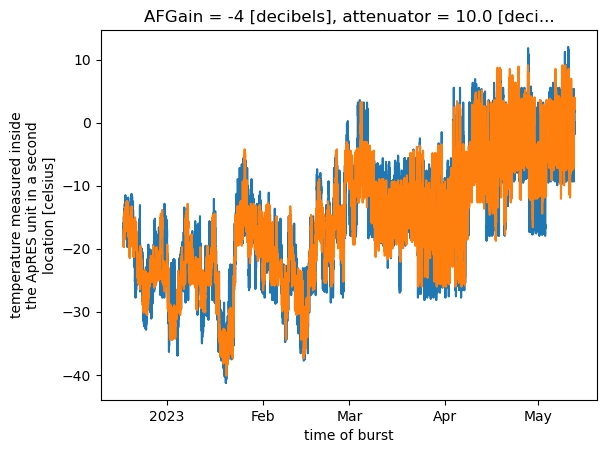

In [5]:
true_temp1 = snippet.temperature_1.where(lambda x: x<300, snippet.temperature_1-512)
true_temp2 = snippet.temperature_2.where(lambda x: x<300, snippet.temperature_2-512)

true_temp1.plot()
true_temp2.plot()

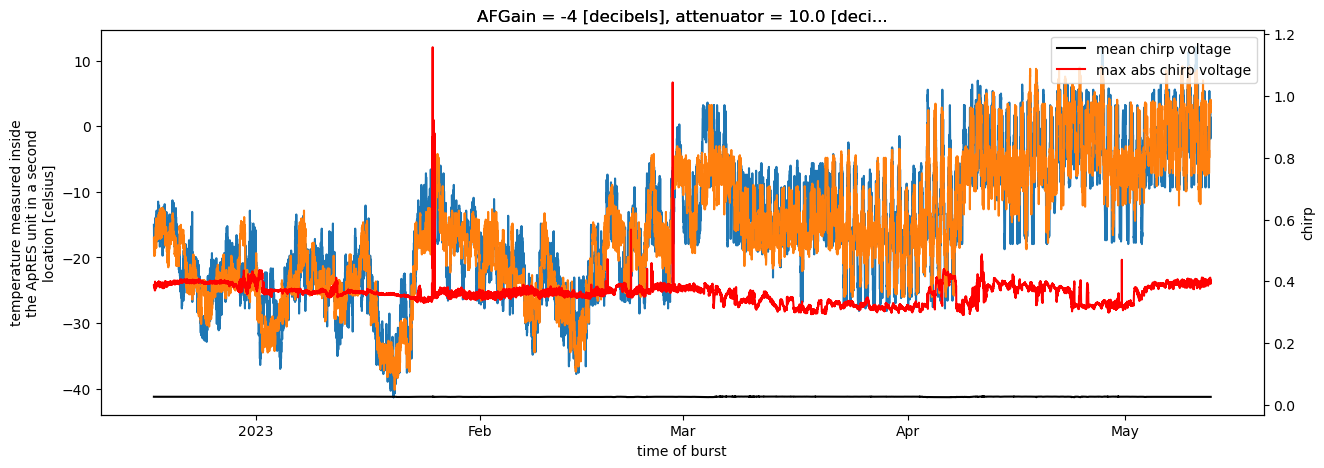

In [6]:
fig, ax1 = plt.subplots(figsize=(15,5))
true_temp1.plot(ax=ax1,label = 'Temperature 1')
true_temp2.plot(ax=ax1,label = 'Temperature 2')
ax2 = ax1.twinx()
snippet.chirp.mean(dim=['chirp_time','chirp_num']).plot(ax=ax2,x='time', color='k',label = 'mean chirp voltage')
np.abs(snippet.chirp).max(dim=['chirp_time','chirp_num']).plot(ax=ax2,x='time', color='r',label = 'max abs chirp voltage')

plt.legend()

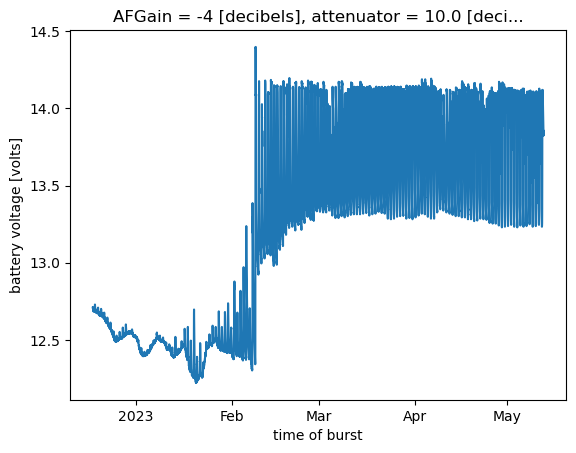

In [7]:
snippet.battery_voltage.plot()

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))
snippet.battery_voltage.plot(ax=ax1)
ax2 = ax1.twinx()
snippet.chirp.mean(dim=['chirp_time','chirp_num']).plot(ax=ax2,x='time', color='k',label = 'mean chirp voltage')
np.abs(snippet.chirp).max(dim=['chirp_time','chirp_num']).plot(ax=ax2,x='time', color='r',label = 'max abs chirp voltage')

plt.legend()
ax1.set_xlim([0.2,0.6])

In [11]:
# determine profiles
def custom_profile(chirps,clip_threshold=1.2,min_chirps = 20,start=0,stop=39999,pad=2):
    # This stop of 39999 by default cuts off the last two samples
    # This function requires starting on an even number
    times = chirps.chirp_time.values.astype('float64')/1e9
    regular_freq_range = 2e8+2e8*times
    start_freq = regular_freq_range[start]
    stop_freq = regular_freq_range[stop-1]
    B = stop_freq - start_freq
    CentreFreq = B/2
    K = 2e8 # determined from step-up freq (5000 Hz) and step-up time (2.5e-5)
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = times[start]
    T1 = times[stop-1]

    # Drop bad bursts
    chirps = chirps.isel(chirp_time=range(start,stop))
    bad_chirps =  chirps.where(chirps > clip_threshold)
    good_bursts = bad_chirps.max(dim='chirp_time').count(dim='chirp_num') <= 20-min_chirps
    chirps = chirps.where(good_bursts)
    chirps = chirps.where(chirps.max(dim='chirp_time')<clip_threshold)

    # De-mean and detrend
    chirps = chirps - chirps.mean(dim='chirp_time')
    p = chirps.polyfit('chirp_time',1)
    fit = xr.polyval(chirps.chirp_time, p.polyfit_coefficients)
    chirps = chirps - fit
    chirps = chirps.mean(dim='chirp_num',skipna=True)
    
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nt = math.floor(Nt/2) * 2
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

In [ ]:
test = custom_profile(ds_101_w.isel(attenuator_setting_pair = 0,time=range(8000,22000)).chirp,clip_threshold=1.2,min_chirps = 20,start=200)

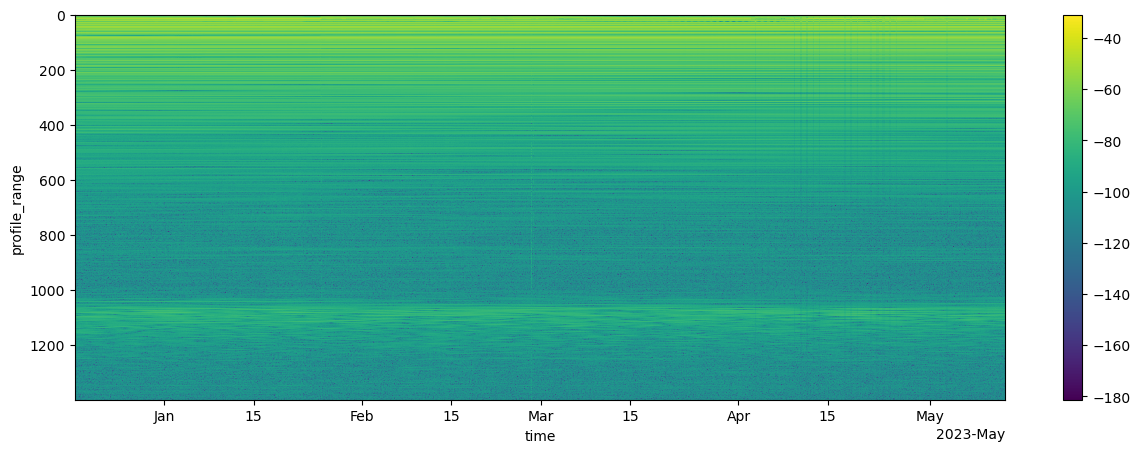

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(test).plot(x='time')
ax.invert_yaxis()

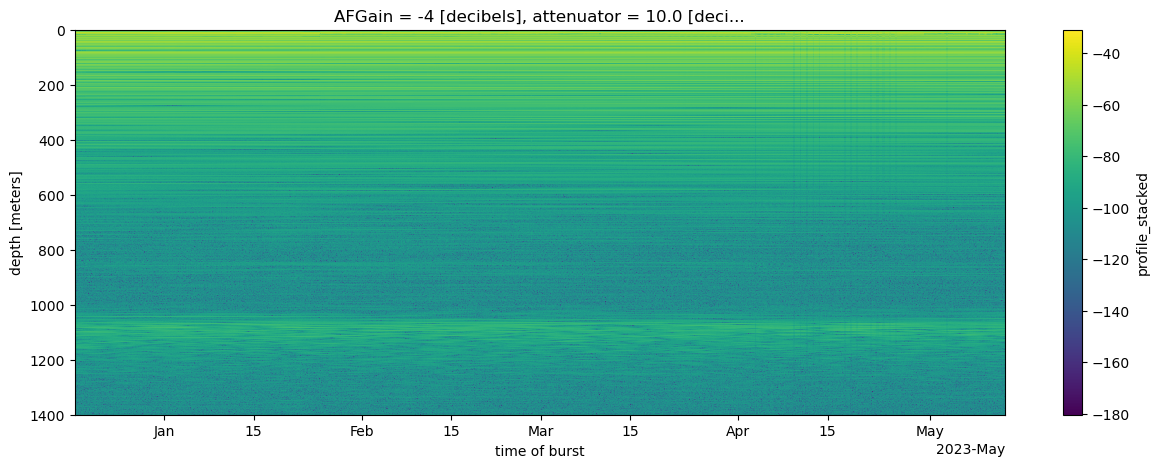

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(snippet.profile_stacked).plot(x='time')
ax.invert_yaxis()

# Aside validating FFT

In [9]:
test_chirp = ds_101_w.isel(time=100,attenuator_setting_pair=0,chirp_num = 5).chirp.compute()

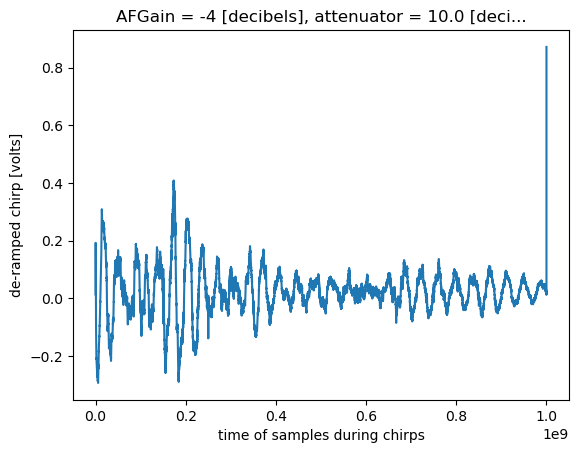

In [10]:
test_chirp.plot()

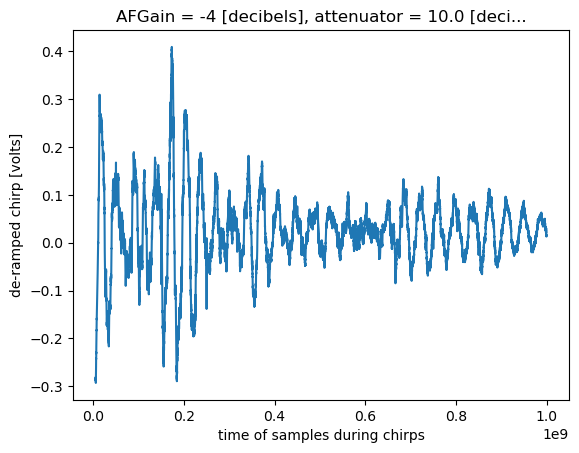

In [13]:
# trim
trimmed_chirp = test_chirp.isel(chirp_time=range(200,39999))
trimmed_chirp.plot()

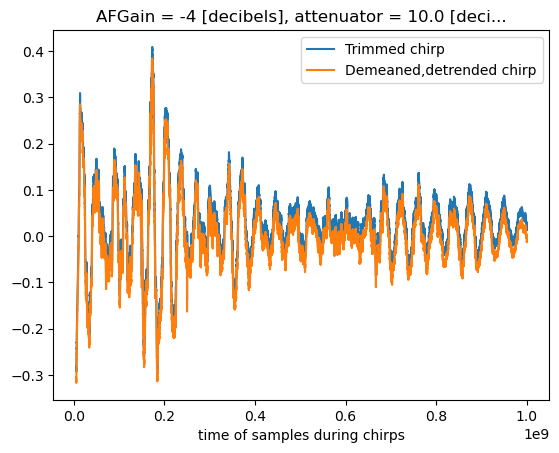

In [17]:
# de-mean, detrend
chirps = trimmed_chirp - trimmed_chirp.mean(dim='chirp_time')
p = chirps.polyfit('chirp_time',1)
fit = xr.polyval(chirps.chirp_time, p.polyfit_coefficients)
chirps = chirps - fit
trimmed_chirp.plot(label='Trimmed chirp')
chirps.plot(label='Demeaned,detrended chirp')
plt.legend()

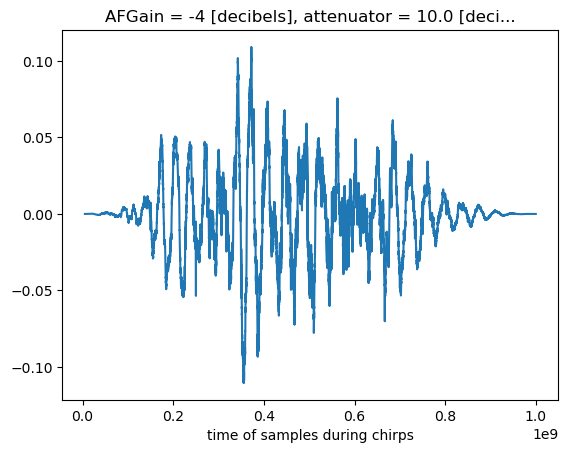

In [19]:
# windowing
window = np.blackman(len(chirps.chirp_time))
win_chirps = chirps*window
Nt = len(chirps.chirp_time)
Nt = math.floor(Nt/2) * 2
Nfft = math.floor(Nt*2)
win_chirps.plot()

Text(0.5, 0, 'number of samples')

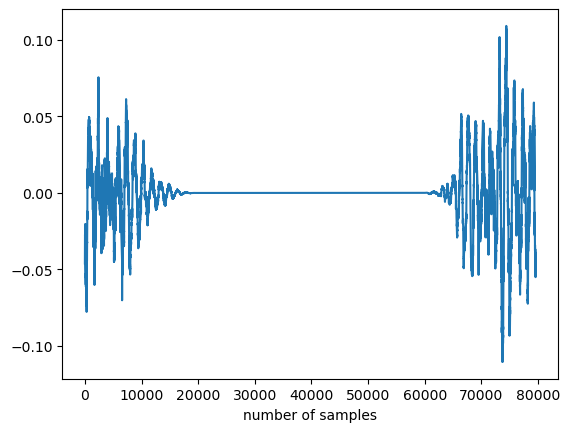

In [26]:
# padding and rotate
padchirp = np.zeros(Nfft)
padchirp[0:math.floor(Nt/2)] = win_chirps.data[math.floor(Nt/2):-1]
padchirp[-math.floor(Nt/2):] = win_chirps.data[0:math.floor(Nt/2)]
plt.plot(padchirp)
plt.xlabel('number of samples')

In [27]:
def shift_bit_length(x):
    return 1<<(x-1).bit_length()

In [37]:
# compare lengths
print(f"current array length: {Nfft}")
print(f"closest power of 2: {shift_bit_length(Nfft)}")

current array length: 79596
closest power of 2: 131072


Text(0.5, 0, 'number of samples')

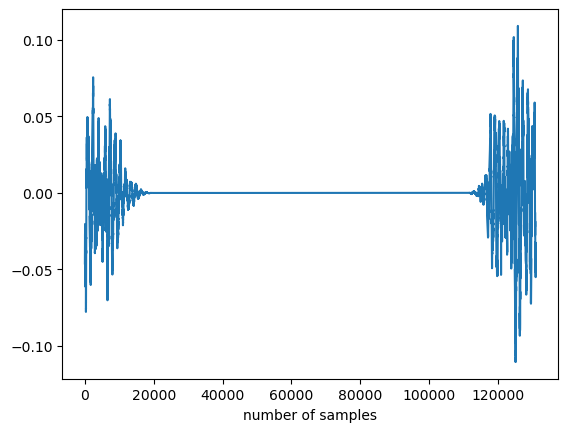

In [38]:
# padding and rotate with cloest power of 2
padchirp_2 = np.zeros(shift_bit_length(Nfft))
padchirp_2[0:math.floor(Nt/2)] = win_chirps.data[math.floor(Nt/2):-1]
padchirp_2[-math.floor(Nt/2):] = win_chirps.data[0:math.floor(Nt/2)]
plt.plot(padchirp_2)
plt.xlabel('number of samples')

In [53]:
p = np.fft.fft(padchirp)/Nfft * math.sqrt(2*2)
p2 = np.fft.fft(padchirp_2)/shift_bit_length(Nfft) * math.sqrt(2*3)

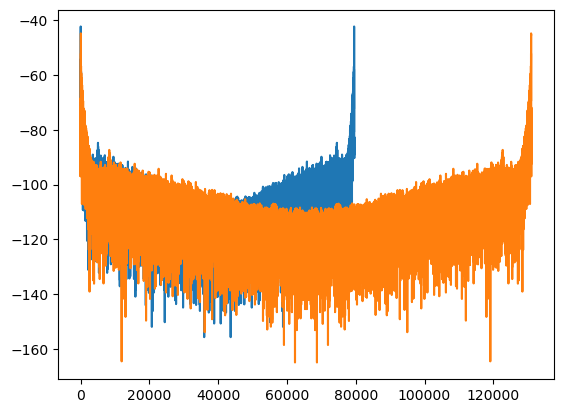

In [54]:
plt.plot(xa.dB(p))
plt.plot(xa.dB(p2))

In [50]:
p2.shape

(79596,)

In [52]:
p.shape

(79596,)

In [57]:
shift_bit_length(Nfft)/Nt

3.2934318307452637